In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tabulate import tabulate
import pprint
from plydata import define, query, select, head, do, group_by, summarize, arrange, left_join, distinct 

In [9]:
def print_table(table):
    print(tabulate(table, headers='keys', showindex=False, tablefmt='presto'))

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [3]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow v" + tf.__version__)
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow v2.14.0
Found TensorFlow Decision Forests v1.6.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load a sample dataset (for example, the Iris dataset)
from sklearn.datasets import load_iris

In [13]:
iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['target'] = iris.target

In [14]:
print_table(data >> head())

   sepal length (cm) |   sepal width (cm) |   petal length (cm) |   petal width (cm) |   target
---------------------+--------------------+---------------------+--------------------+----------
                 5.1 |                3.5 |                 1.4 |                0.2 |        0
                 4.9 |                3   |                 1.4 |                0.2 |        0
                 4.7 |                3.2 |                 1.3 |                0.2 |        0
                 4.6 |                3.1 |                 1.5 |                0.2 |        0
                 5   |                3.6 |                 1.4 |                0.2 |        0


In [23]:
df = data[data['target'] != 2]

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [24]:
y_train

9     0
51    1
29    0
88    1
75    1
     ..
76    1
53    1
38    0
83    1
47    0
Name: target, Length: 80, dtype: int64

In [30]:
X_train.shape

(80, 4)

In [26]:
pd.DataFrame(y_train)

,target
9,0
51,1
29,0
88,1
75,1
...,...
76,1
53,1
38,0
83,1


In [34]:
# Convert data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, pd.DataFrame(y_train)], ignore_index=False, axis=1), label="target", task=tfdf.keras.Task.CLASSIFICATION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_test, pd.DataFrame(y_test)], ignore_index=False, axis=1), label="target", task=tfdf.keras.Task.CLASSIFICATION)

In [62]:
# Create a Random Forest model
model = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True, 
                                     random_seed=8888, 
                                     num_trees=200, 
                                     max_depth=5,
                                     name='random_forest_model',
                                     task=tfdf.keras.Task.CLASSIFICATION
                                    )

Use /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmp9_llioqd as temporary training directory


In [63]:
metrics = [
    tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [64]:
model.compile(metrics=metrics)

In [65]:
%%time
model.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.102214. Found 80 examples.
Training model...
Model trained in 0:00:00.011831
Compiling model...
Model compiled.
CPU times: user 165 ms, sys: 11.4 ms, total: 176 ms
Wall time: 166 ms


[INFO 23-11-27 20:51:46.1890 PST kernel.cc:1233] Loading model from path /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmp9_llioqd/model/ with prefix 31826d265795432a
[INFO 23-11-27 20:51:46.1904 PST decision_forest.cc:660] Model loaded with 200 root(s), 600 node(s), and 2 input feature(s).
[INFO 23-11-27 20:51:46.1904 PST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-27 20:51:46.1904 PST kernel.cc:1061] Use fast generic engine


In [66]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	petal_length_(cm)
	petal_width_(cm)
	sepal_length_(cm)
	sepal_width_(cm)

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "petal_length_(cm)"  0.673401 ################
    2.  "petal_width_(cm)"  0.660066 

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1. "petal_length_(cm)"  0.000000 
    2.  "petal_width_(cm)"  0.000000 
    3. "sepal_length_(cm)"  0.000000 
    4.  "sepal_width_(cm)"  0.000000 

Variable Importance: MEAN_DECREASE_IN_AP_2_VS_OTHERS:
    1.  "petal_width_(cm)"  0.000000 ################
    2. "petal_length_(cm)"  0.000000 
    3. "sepal_length_(cm)"  

In [67]:
tf.print(model.evaluate(test_ds, return_dict=True, verbose=1))

1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - cross entropy: 4.2617e-07 - mse: 3.9027e-13 - tp: 13.0000 - fp: 0.0000e+00 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
{'accuracy': 1.0,
 'auc': 1.0,
 'cross entropy': 4.2617330109351315e-07,
 'fn': 0.0,
 'fp': 0.0,
 'loss': 0.0,
 'mse': 3.9026559219522416e-13,
 'prc': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'tn': 7.0,
 'tp': 13.0}


In [68]:
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [69]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

In [46]:
# Evaluate the model on the test set
predictions = model.predict(test_ds)

1/1 [==============================] - 0s 30ms/step


In [70]:
predictions.shape

(20, 1)

In [71]:
predictions

array([[0.       ],
       [0.       ],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.9999992],
       [0.       ],
       [0.9999992],
       [0.9999992]], dtype=float32)

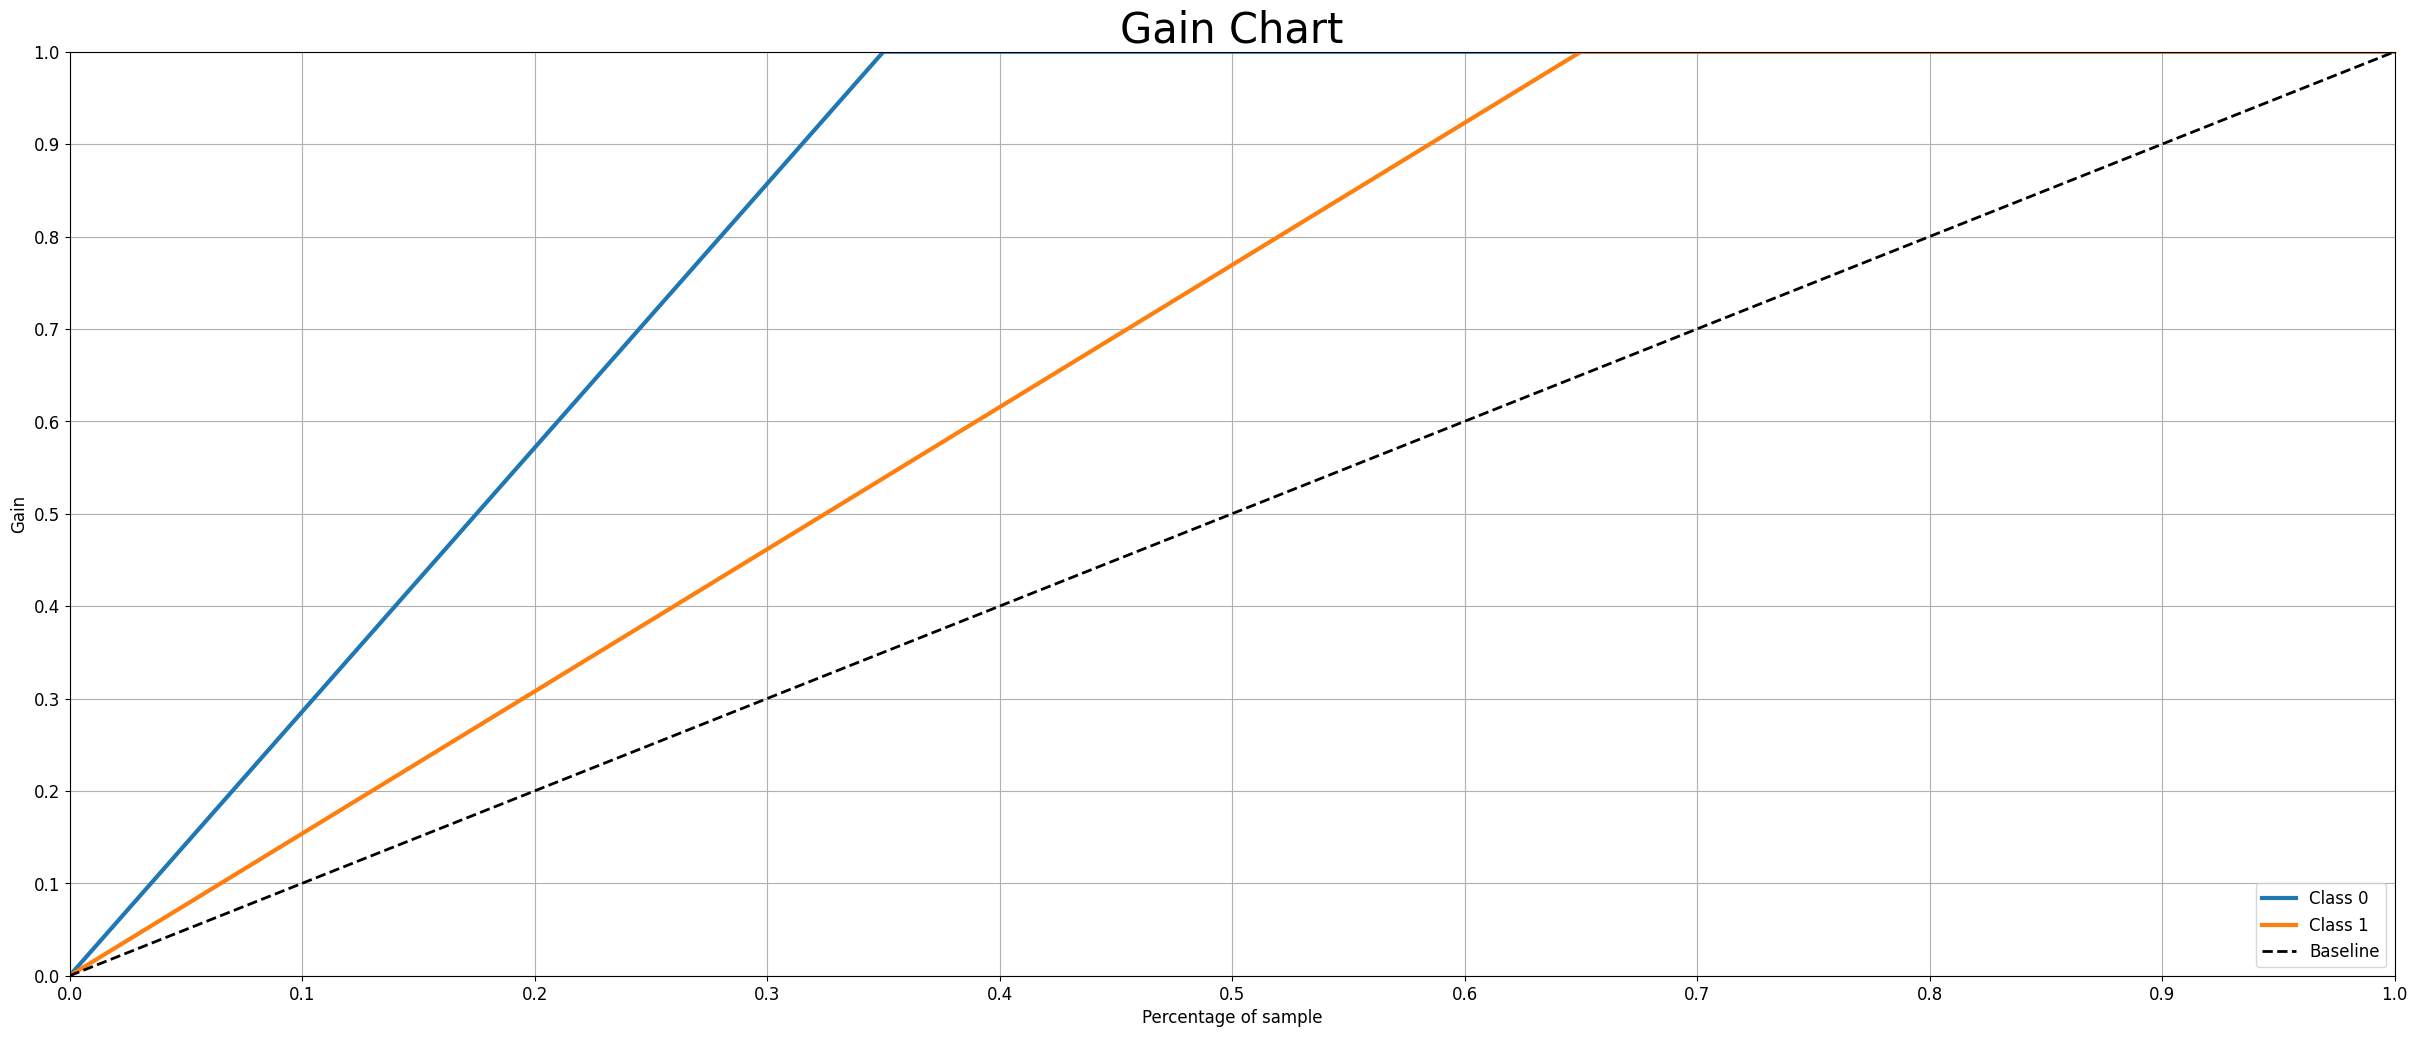

In [80]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(
    np.array(y_test),
    np.column_stack((1-predictions[:,0],predictions[:,0])),
    figsize=(30,12),
    title_fontsize=20,
    text_fontsize=12
)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,step=0.1))
plt.yticks(np.arange(0,1.1,step=0.1))
plt.title("Gain Chart", size=30),
plt.rc('lines', linewidth=1.5, color='r')
plt.show()

### Gradient Boosted Trees model

In [83]:
# Create a Gradient Boosted Trees model
model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)

Use /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmpxmn8_z5u as temporary training directory


[WARNING 23-11-27 21:01:40.0508 PST gradient_boosted_trees.cc:1830] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-27 21:01:40.0518 PST gradient_boosted_trees.cc:1841] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-27 21:01:40.0519 PST gradient_boosted_trees.cc:1855] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [84]:
metrics = [
    tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [85]:
model.compile(metrics=metrics)

In [86]:
%%time
model.fit(x=train_ds)

Reading training dataset...


Training dataset read in 0:00:00.105583. Found 80 examples.
Training model...
Model trained in 0:00:00.150409
Compiling model...
Model compiled.


[INFO 23-11-27 21:01:40.9030 PST kernel.cc:1233] Loading model from path /var/folders/zk/3vgrnry578s2pljd4gcb7f6r0000gn/T/tmpxmn8_z5u/model/ with prefix a22f2c860a764418
[INFO 23-11-27 21:01:40.9094 PST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-11-27 21:01:40.9094 PST kernel.cc:1061] Use fast generic engine


CPU times: user 251 ms, sys: 199 ms, total: 450 ms
Wall time: 309 ms


In [87]:
tf.print(model.evaluate(test_ds, return_dict=True, verbose=1))

1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - cross entropy: 2.9266e-06 - mse: 1.5035e-11 - tp: 13.0000 - fp: 0.0000e+00 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
{'accuracy': 1.0,
 'auc': 1.0,
 'cross entropy': 2.9265952434798237e-06,
 'fn': 0.0,
 'fp': 0.0,
 'loss': 0.0,
 'mse': 1.503452744244793e-11,
 'prc': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'tn': 7.0,
 'tp': 13.0}
